# 📈 모델 성능 평가 및 시각화

이 노트북은 학습된 모델의 성능을 다양한 지표로 평가하고 시각화합니다.

## 목차
1. 모델 로딩 및 데이터 준비
2. 기본 성능 지표 계산
3. Confusion Matrix 시각화
4. ROC Curve & AUC
5. Precision-Recall Curve
6. Feature Importance 분석
7. Learning Curve
8. Cross-Validation 결과
9. SHAP 분석 (선택)

In [29]:
# 라이브러리 임포트
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score, auc,
    precision_recall_curve, average_precision_score,
    classification_report
)

# matplotlib 캐시 삭제 및 폰트 재로드
import matplotlib
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

# 한글 폰트 직접 지정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 폰트 확인
print(f"✅ 현재 폰트: {plt.rcParams['font.family']}")

# 스타일 설정
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ 라이브러리 임포트 완료')

✅ 현재 폰트: ['Malgun Gothic']
✅ 라이브러리 임포트 완료


## 1. 모델 로딩 및 데이터 준비

### ⚠️ 중요: Pipeline과 데이터 처리

**Pipeline 구조를 이해하고 올바른 데이터를 입력해야 합니다:**

현재 저장된 Pipeline 구조:
```
Pipeline([
    ('preprocessor', ColumnTransformer),  # StandardScaler + OneHotEncoder
    ('clf', Model)                         # 학습된 모델
])
```

따라서:
1. **Raw 데이터 사용**: `dataset.csv` (원본 데이터)
2. **수동 전처리만**: Enrolled 제거, 타깃 인코딩, 특성 선택
3. **Pipeline이 자동 처리**: 스케일링 및 인코딩은 Pipeline에서 자동 수행
4. **동일한 분할**: `random_state=42`로 학습 시와 동일한 분할

In [30]:
# 모델 로딩
MODEL_PATH = Path('../model/model_trained.pkl')
DATA_PATH = Path('../data/raw/dataset.csv')  # ✅ Raw 데이터 사용 (Pipeline이 전처리 수행)

if not MODEL_PATH.exists():
    raise FileNotFoundError(f'모델 파일을 찾을 수 없습니다: {MODEL_PATH}')

if not DATA_PATH.exists():
    raise FileNotFoundError(f'데이터 파일을 찾을 수 없습니다: {DATA_PATH}')

pipeline = joblib.load(MODEL_PATH)
print(f'✅ 모델 로딩 완료: {MODEL_PATH}')
print(f'모델 타입: {type(pipeline).__name__}')

# Pipeline 구조 확인
if hasattr(pipeline, 'named_steps'):
    print(f'\nPipeline 단계:')
    for step_name in pipeline.named_steps.keys():
        print(f'  - {step_name}: {type(pipeline.named_steps[step_name]).__name__}')

✅ 모델 로딩 완료: ..\model\model_trained.pkl
모델 타입: Pipeline

Pipeline 단계:
  - preprocessor: ColumnTransformer
  - clf: RandomForestClassifier


In [31]:
# 데이터 로딩 및 전처리
df = pd.read_csv(DATA_PATH)
print(f'✅ 데이터 로드 완료: {df.shape[0]:,}행 × {df.shape[1]}열')

# Enrolled 제거 (학습 시와 동일)
df = df[df['Target'] != 'Enrolled'].copy()

# 타깃 인코딩
TARGET_MAPPING = {'Dropout': 0, 'Graduate': 1}
df['Target'] = df['Target'].map(TARGET_MAPPING)

# 특징/타깃 분리
feature_cols = [col for col in df.columns if col != 'Target']
X = df[feature_cols]
y = df['Target']

# ⚠️ 학습 시와 동일한 특성 선택 과정 적용
columns_to_drop = set()

# 1. 식별자 및 상수 컬럼 제거
id_like = [col for col in feature_cols if 'id' in col.lower()]
constant_cols = [col for col in feature_cols if X[col].nunique(dropna=False) <= 1]
columns_to_drop.update(id_like)
columns_to_drop.update(constant_cols)

# 2. 타깃과 상관이 거의 없는 수치 컬럼 제거
numeric_candidates = X.select_dtypes(include=['number']).columns.tolist()
low_corr_numeric = []
for col in numeric_candidates:
    corr = X[col].corr(y)
    if pd.isna(corr) or abs(corr) < 0.02:
        low_corr_numeric.append(col)
columns_to_drop.update(low_corr_numeric)

# 3. 고유값 비율이 높은 범주형 컬럼 제거
categorical_candidates = X.select_dtypes(include=['object', 'category']).columns.tolist()
high_cardinality = [
    col for col in categorical_candidates 
    if (X[col].nunique(dropna=False) / len(X)) > 0.6
]
columns_to_drop.update(high_cardinality)

if columns_to_drop:
    print(f'제거 컬럼: {sorted(columns_to_drop)}')
    X = X.drop(columns=columns_to_drop)

# Train/Test 분할 (학습 시와 동일한 random_state 사용)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f'\n✅ 데이터 분할 완료:')
print(f'  - X_train: {X_train.shape}')
print(f'  - X_test: {X_test.shape}')
print(f'  - y_train: Dropout {(y_train == 0).sum()}, Graduate {(y_train == 1).sum()}')
print(f'  - y_test: Dropout {(y_test == 0).sum()}, Graduate {(y_test == 1).sum()}')

✅ 데이터 로드 완료: 4,424행 × 35열
제거 컬럼: ['Course', 'Educational special needs', "Father's qualification", 'International', 'Nacionality', 'Unemployment rate']

✅ 데이터 분할 완료:
  - X_train: (2904, 28)
  - X_test: (726, 28)
  - y_train: Dropout 1137, Graduate 1767
  - y_test: Dropout 284, Graduate 442
제거 컬럼: ['Course', 'Educational special needs', "Father's qualification", 'International', 'Nacionality', 'Unemployment rate']

✅ 데이터 분할 완료:
  - X_train: (2904, 28)
  - X_test: (726, 28)
  - y_train: Dropout 1137, Graduate 1767
  - y_test: Dropout 284, Graduate 442


In [32]:
# 예측 수행
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

print('✅ 예측 완료')
print(f'예측 결과: Dropout {(y_pred == 0).sum()}, Graduate {(y_pred == 1).sum()}')

✅ 예측 완료
예측 결과: Dropout 248, Graduate 478


## 2. 기본 성능 지표 계산

In [33]:
# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('='*60)
print('📊 모델 성능 지표')
print('='*60)
print(f'Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)')
print(f'Precision: {precision:.4f} ({precision*100:.2f}%)')
print(f'Recall:    {recall:.4f} ({recall*100:.2f}%)')
print(f'F1-score:  {f1:.4f} ({f1*100:.2f}%)')
print('='*60)

📊 모델 성능 지표
Accuracy:  0.9146 (91.46%)
Precision: 0.8975 (89.75%)
Recall:    0.9706 (97.06%)
F1-score:  0.9326 (93.26%)


In [34]:
# Classification Report
print('\n=== Classification Report ===')
print(classification_report(y_test, y_pred, target_names=['Dropout', 'Graduate']))


=== Classification Report ===
              precision    recall  f1-score   support

     Dropout       0.95      0.83      0.88       284
    Graduate       0.90      0.97      0.93       442

    accuracy                           0.91       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.91      0.91       726



## 3. Confusion Matrix 시각화

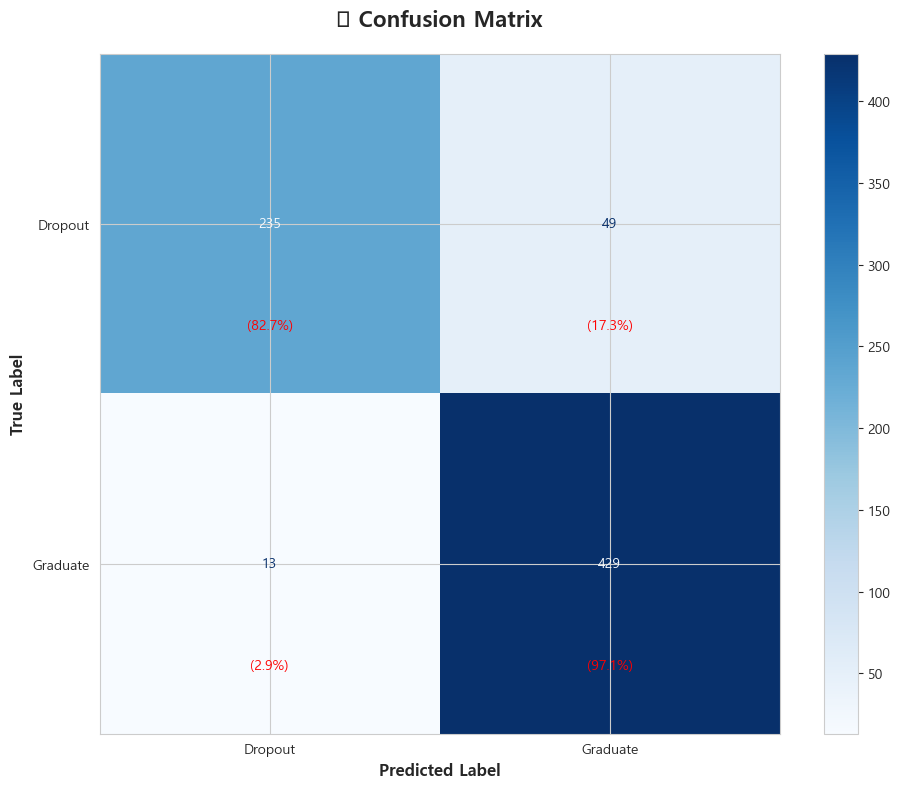

✅ 그래프 저장: figures/confusion_matrix.png

=== Confusion Matrix 상세 분석 ===
True Negative (TN):  235 (Graduate → Graduate 정확 예측)
False Positive (FP):  49 (Graduate → Dropout 오분류)
False Negative (FN):  13 (Dropout → Graduate 오분류) ⚠️
True Positive (TP):  429 (Dropout → Dropout 정확 예측) ✅

False Negative Rate: 2.94% (놓친 Dropout 학생 비율)
False Positive Rate: 17.25% (오탐 비율)


In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 시각화
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dropout', 'Graduate'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('🔍 Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')

# 값 추가 표시
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j, i + 0.3, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.savefig('../figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ 그래프 저장: figures/confusion_matrix.png')

# 상세 분석
tn, fp, fn, tp = cm.ravel()
print(f'\n=== Confusion Matrix 상세 분석 ===')
print(f'True Negative (TN):  {tn:3d} (Graduate → Graduate 정확 예측)')
print(f'False Positive (FP): {fp:3d} (Graduate → Dropout 오분류)')
print(f'False Negative (FN): {fn:3d} (Dropout → Graduate 오분류) ⚠️')
print(f'True Positive (TP):  {tp:3d} (Dropout → Dropout 정확 예측) ✅')
print(f'\nFalse Negative Rate: {fn/(fn+tp)*100:.2f}% (놓친 Dropout 학생 비율)')
print(f'False Positive Rate: {fp/(fp+tn)*100:.2f}% (오탐 비율)')

## 4. ROC Curve & AUC

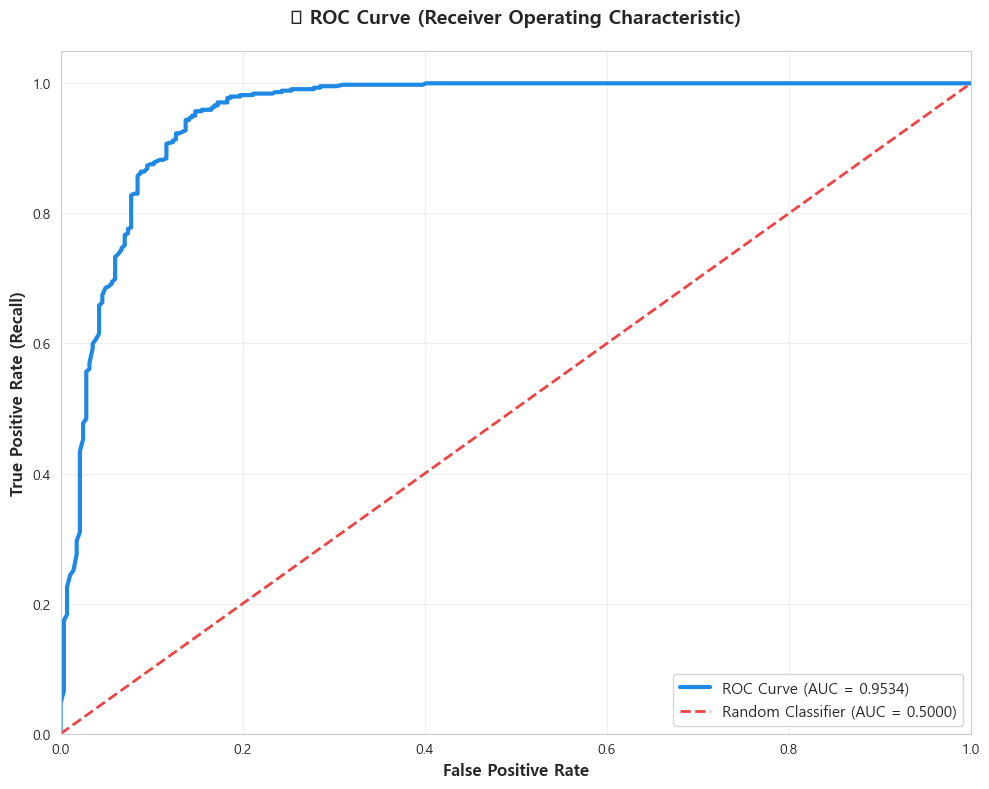

✅ 그래프 저장: figures/roc_curve.png

📊 ROC-AUC Score: 0.9534
   → Excellent (매우 우수한 성능) ✅


In [36]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

# 시각화
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#1e88e5', lw=3, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#ef4444', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
plt.title('📈 ROC Curve (Receiver Operating Characteristic)', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ 그래프 저장: figures/roc_curve.png')
print(f'\n📊 ROC-AUC Score: {roc_auc:.4f}')

if roc_auc >= 0.9:
    print('   → Excellent (매우 우수한 성능) ✅')
elif roc_auc >= 0.8:
    print('   → Good (좋은 성능)')
elif roc_auc >= 0.7:
    print('   → Fair (적절한 성능)')
else:
    print('   → Poor (개선 필요)')

## 5. Precision-Recall Curve

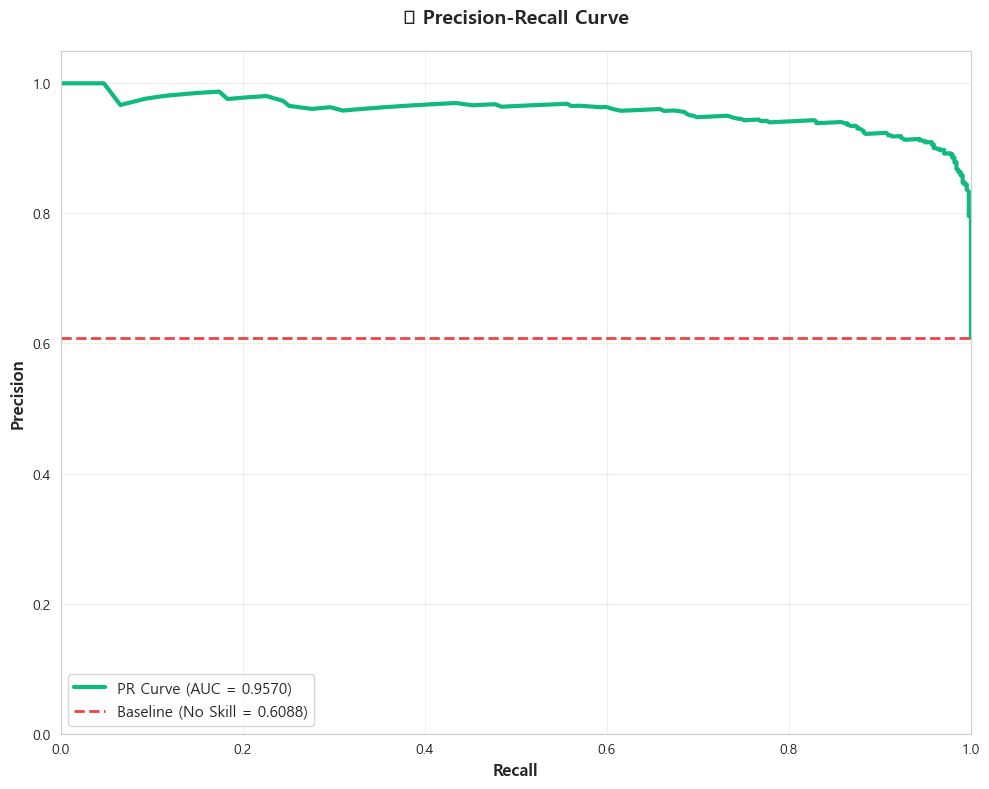

✅ 그래프 저장: figures/precision_recall_curve.png

📊 Precision-Recall AUC: 0.9570


In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# Precision-Recall Curve 계산
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
pr_auc = average_precision_score(y_test, y_pred_proba[:, 1])

# 시각화
plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='#10b981', lw=3, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.axhline(y=(y_test == 1).sum() / len(y_test), color='#ef4444', lw=2, linestyle='--', 
            label=f'Baseline (No Skill = {(y_test == 1).sum() / len(y_test):.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('📈 Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower left', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ 그래프 저장: figures/precision_recall_curve.png')
print(f'\n📊 Precision-Recall AUC: {pr_auc:.4f}')

## 6. Feature Importance 분석

In [38]:
# Feature Importance 추출
if hasattr(pipeline, 'feature_importances_'):
    importances = pipeline.feature_importances_
    feature_names = pipeline.feature_names_in_
elif hasattr(pipeline, 'named_steps'):
    # Pipeline인 경우
    model = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]]
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = pipeline.feature_names_in_
    else:
        print('⚠️ 이 모델은 Feature Importance를 제공하지 않습니다.')
        importances = None
else:
    print('⚠️ Feature Importance를 추출할 수 없습니다.')
    importances = None

=== Top 20 Feature Importance ===
                               Feature  Importance  Importance_pct
   Curricular units 2nd sem (approved)    0.210291       21.029135
   Curricular units 1st sem (approved)    0.125963       12.596274
      Curricular units 2nd sem (grade)    0.124834       12.483390
      Curricular units 1st sem (grade)    0.090066        9.006604
               Tuition fees up to date    0.059529        5.952862
                     Age at enrollment    0.041035        4.103536
Curricular units 2nd sem (evaluations)    0.037617        3.761749
Curricular units 1st sem (evaluations)    0.029676        2.967567
                   Father's occupation    0.025634        2.563439
   Curricular units 2nd sem (enrolled)    0.024065        2.406488
   Curricular units 1st sem (enrolled)    0.023238        2.323817
                      Application mode    0.022826        2.282590
                   Mother's occupation    0.022075        2.207525
                            

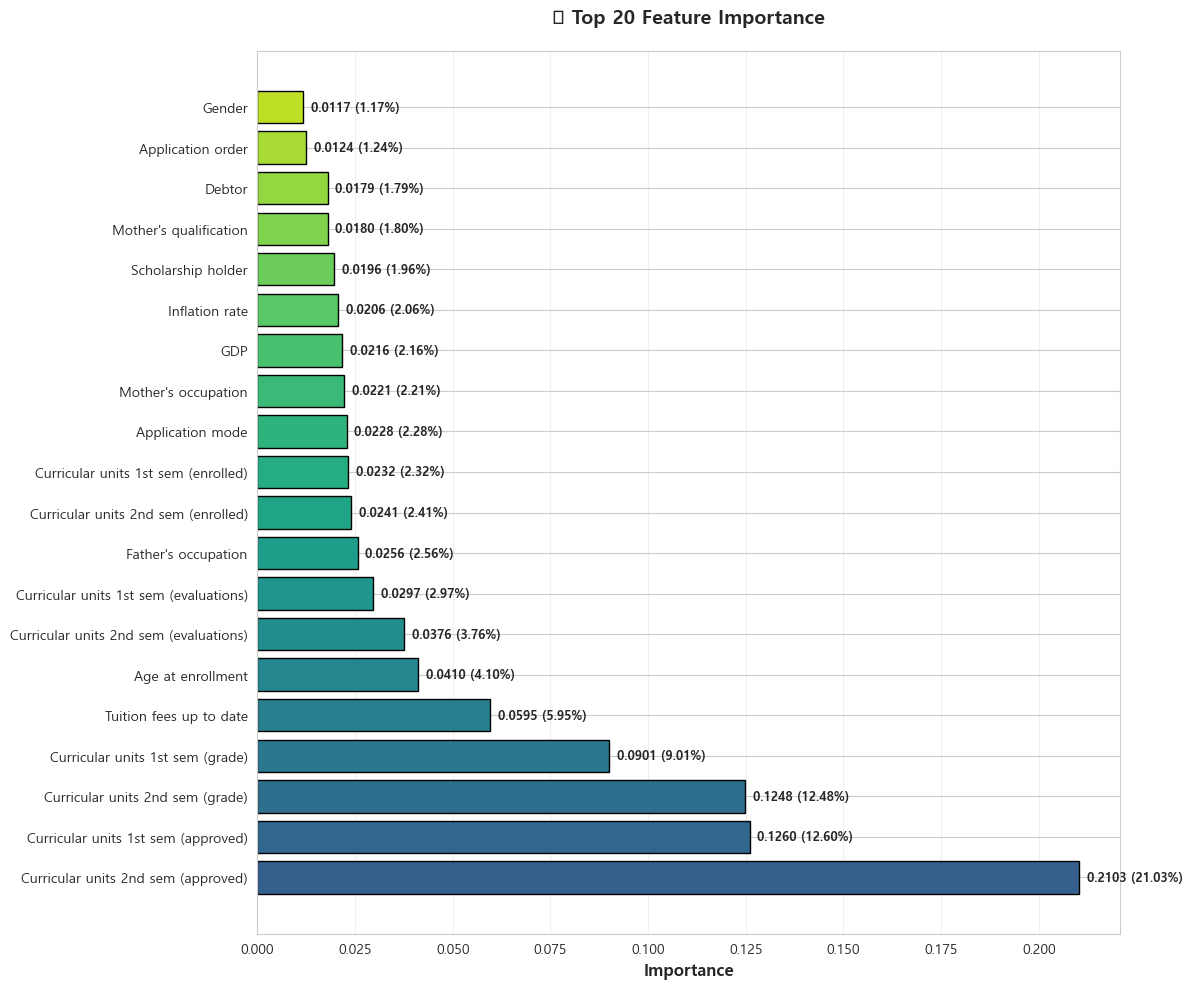


✅ 그래프 저장: figures/feature_importance.png

📌 주요 인사이트:
1. 가장 중요한 변수: Curricular units 2nd sem (approved) (21.03%)
2. 상위 5개 변수 중요도 합: 61.07%
3. 상위 10개 변수 중요도 합: 76.87%


In [39]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

if importances is not None:
    # 상위 20개 추출
    indices = np.argsort(importances)[::-1][:20]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]
    
    # DataFrame 생성
    importance_df = pd.DataFrame({
        'Feature': top_features,
        'Importance': top_importances,
        'Importance_pct': top_importances * 100
    })
    
    print('=== Top 20 Feature Importance ===')
    print(importance_df.to_string(index=False))
    
    # 시각화
    plt.figure(figsize=(12, 10))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_importances)))
    plt.barh(range(len(top_importances)), top_importances, color=colors, edgecolor='black')
    plt.yticks(range(len(top_importances)), top_features, fontsize=10)
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title('🔥 Top 20 Feature Importance', fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)
    
    # 값 표시
    for i, v in enumerate(top_importances):
        plt.text(v + 0.002, i, f'{v:.4f} ({v*100:.2f}%)', 
                va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\n✅ 그래프 저장: figures/feature_importance.png')
    
    # 주요 인사이트
    print(f'\n📌 주요 인사이트:')
    print(f'1. 가장 중요한 변수: {top_features[0]} ({top_importances[0]*100:.2f}%)')
    print(f'2. 상위 5개 변수 중요도 합: {top_importances[:5].sum()*100:.2f}%')
    print(f'3. 상위 10개 변수 중요도 합: {top_importances[:10].sum()*100:.2f}%')

## 7. Learning Curve

⏳ Learning Curve 계산 중... (시간이 다소 소요됩니다)


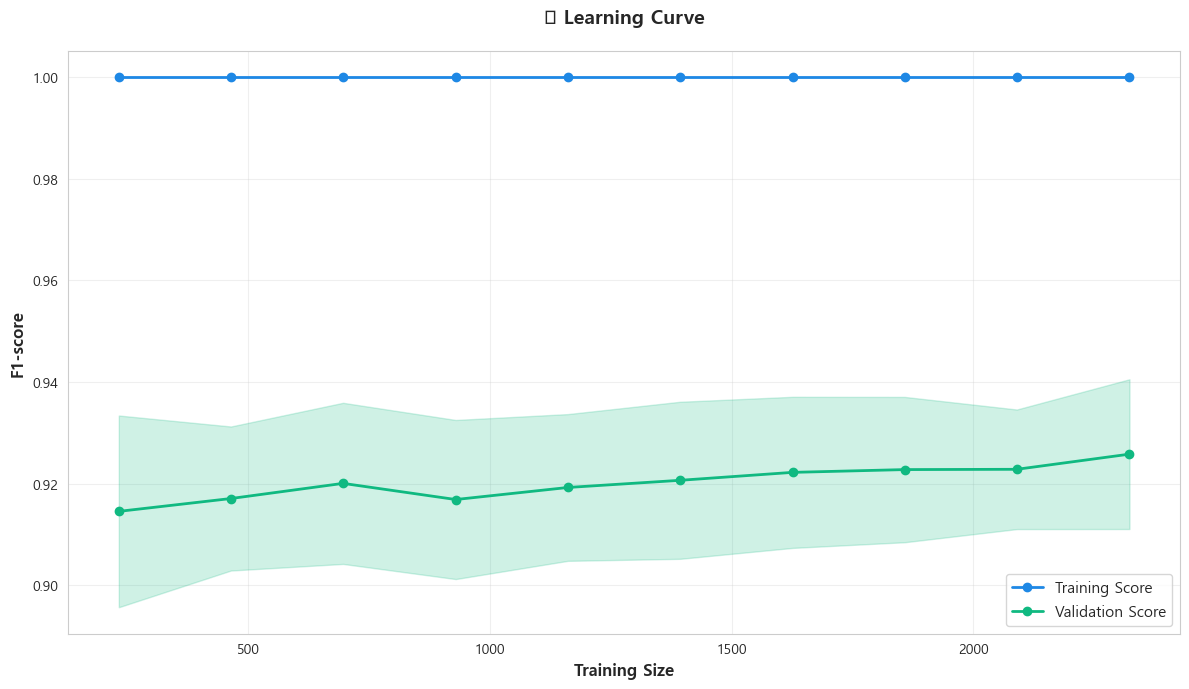

✅ 그래프 저장: figures/learning_curve.png

=== Learning Curve 분석 ===
최종 Train Score: 1.0000
최종 Validation Score: 0.9258
Train-Val Gap: 0.0742 (7.42%)
   → 경미한 과적합, 허용 가능


In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# Learning Curve 계산 (시간이 오래 걸릴 수 있음)
print('⏳ Learning Curve 계산 중... (시간이 다소 소요됩니다)')

train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

# 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 시각화
plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean, 'o-', color='#1e88e5', lw=2, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='#1e88e5')

plt.plot(train_sizes, val_mean, 'o-', color='#10b981', lw=2, label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color='#10b981')

plt.xlabel('Training Size', fontsize=12, fontweight='bold')
plt.ylabel('F1-score', fontsize=12, fontweight='bold')
plt.title('📊 Learning Curve', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ 그래프 저장: figures/learning_curve.png')

# 분석
final_train_score = train_mean[-1]
final_val_score = val_mean[-1]
gap = final_train_score - final_val_score

print(f'\n=== Learning Curve 분석 ===')
print(f'최종 Train Score: {final_train_score:.4f}')
print(f'최종 Validation Score: {final_val_score:.4f}')
print(f'Train-Val Gap: {gap:.4f} ({gap*100:.2f}%)')

if gap < 0.05:
    print('   → 과적합 없음, 일반화 성능 우수 ✅')
elif gap < 0.1:
    print('   → 경미한 과적합, 허용 가능')
else:
    print('   → 과적합 주의 ⚠️')

## 8. Cross-Validation 결과

⏳ Cross-Validation 수행 중...

=== 5-Fold Cross-Validation Results ===
Fold 1: F1 = 0.8987
Fold 2: F1 = 0.9369
Fold 3: F1 = 0.9409
Fold 4: F1 = 0.9260
Fold 5: F1 = 0.9250
----------------------------------------
Mean F1: 0.9255 ± 0.0147
Min F1:  0.8987
Max F1:  0.9409

=== 5-Fold Cross-Validation Results ===
Fold 1: F1 = 0.8987
Fold 2: F1 = 0.9369
Fold 3: F1 = 0.9409
Fold 4: F1 = 0.9260
Fold 5: F1 = 0.9250
----------------------------------------
Mean F1: 0.9255 ± 0.0147
Min F1:  0.8987
Max F1:  0.9409


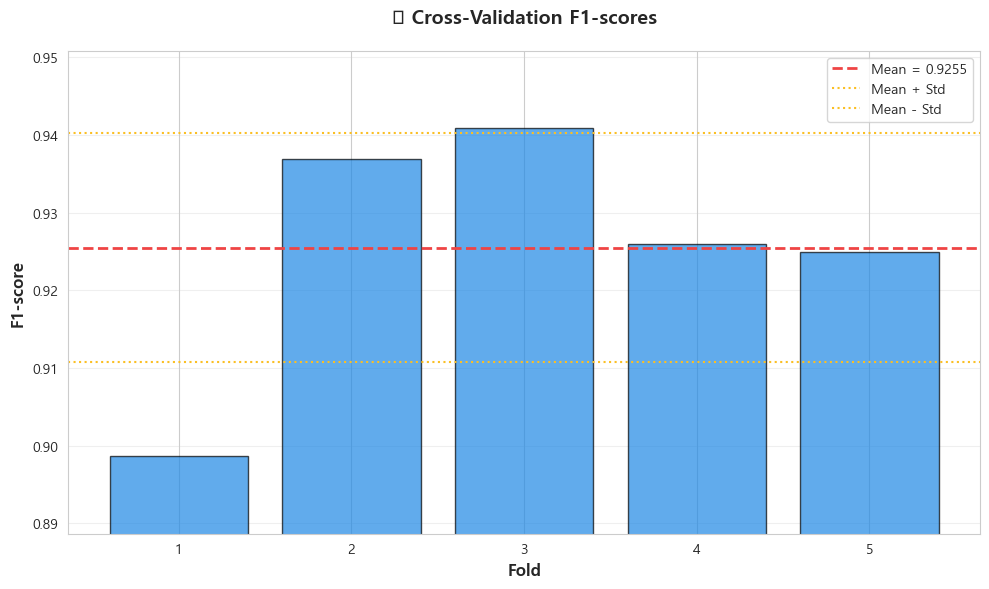


✅ 그래프 저장: figures/cross_validation.png

✅ 표준편차가 낮아 모델 성능이 일관적입니다.


In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 5-Fold Cross-Validation
print('⏳ Cross-Validation 수행 중...')

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)

print('\n=== 5-Fold Cross-Validation Results ===')
for i, score in enumerate(cv_scores, 1):
    print(f'Fold {i}: F1 = {score:.4f}')

print('-' * 40)
print(f'Mean F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
print(f'Min F1:  {cv_scores.min():.4f}')
print(f'Max F1:  {cv_scores.max():.4f}')

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, color='#1e88e5', edgecolor='black', alpha=0.7)
plt.axhline(y=cv_scores.mean(), color='#ef4444', linestyle='--', lw=2, label=f'Mean = {cv_scores.mean():.4f}')
plt.axhline(y=cv_scores.mean() + cv_scores.std(), color='#fbbf24', linestyle=':', lw=1.5, label=f'Mean + Std')
plt.axhline(y=cv_scores.mean() - cv_scores.std(), color='#fbbf24', linestyle=':', lw=1.5, label=f'Mean - Std')
plt.xlabel('Fold', fontsize=12, fontweight='bold')
plt.ylabel('F1-score', fontsize=12, fontweight='bold')
plt.title('📊 Cross-Validation F1-scores', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10)
plt.ylim([cv_scores.min() - 0.01, cv_scores.max() + 0.01])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✅ 그래프 저장: figures/cross_validation.png')

if cv_scores.std() < 0.01:
    print('\n✅ 표준편차가 매우 낮아 모델이 안정적입니다.')
elif cv_scores.std() < 0.02:
    print('\n✅ 표준편차가 낮아 모델 성능이 일관적입니다.')
else:
    print('\n⚠️ 표준편차가 다소 높아 Fold 간 성능 차이가 있습니다.')

## 9. 종합 요약

In [42]:
print('\n' + '='*70)
print('📌 모델 성능 평가 종합 요약')
print('='*70)

print(f'\n1️⃣ 기본 성능 지표:')
print(f'   - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)')
print(f'   - Precision: {precision:.4f} ({precision*100:.2f}%)')
print(f'   - Recall:    {recall:.4f} ({recall*100:.2f}%) ⭐ (핵심 지표)')
print(f'   - F1-score:  {f1:.4f} ({f1*100:.2f}%)')

print(f'\n2️⃣ ROC & PR 곡선:')
print(f'   - ROC-AUC: {roc_auc:.4f}')
print(f'   - PR-AUC:  {pr_auc:.4f}')

print(f'\n3️⃣ Confusion Matrix:')
print(f'   - True Positive:  {tp:3d} (Dropout 정확 예측)')
print(f'   - False Negative: {fn:3d} (Dropout 놓침) → {fn/(fn+tp)*100:.2f}%')
print(f'   - False Positive: {fp:3d} (Graduate 오분류) → {fp/(fp+tn)*100:.2f}%')

print(f'\n4️⃣ Cross-Validation:')
print(f'   - Mean F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
print(f'   - 안정성: {"매우 우수 ✅" if cv_scores.std() < 0.01 else "우수 ✅" if cv_scores.std() < 0.02 else "보통"}')

if importances is not None:
    print(f'\n5️⃣ 주요 변수 (Top 3):')
    for i in range(min(3, len(top_features))):
        print(f'   {i+1}. {top_features[i]}: {top_importances[i]*100:.2f}%')

print(f'\n6️⃣ 저장된 시각화 파일:')
figures_list = [
    'confusion_matrix.png',
    'roc_curve.png',
    'precision_recall_curve.png',
    'feature_importance.png',
    'learning_curve.png',
    'cross_validation.png'
]
for i, filename in enumerate(figures_list, 1):
    print(f'   {i}. figures/{filename}')

print('\n' + '='*70)
print('✅ 모델 평가 완료!')
print('='*70)


📌 모델 성능 평가 종합 요약

1️⃣ 기본 성능 지표:
   - Accuracy:  0.9146 (91.46%)
   - Precision: 0.8975 (89.75%)
   - Recall:    0.9706 (97.06%) ⭐ (핵심 지표)
   - F1-score:  0.9326 (93.26%)

2️⃣ ROC & PR 곡선:
   - ROC-AUC: 0.9534
   - PR-AUC:  0.9570

3️⃣ Confusion Matrix:
   - True Positive:  429 (Dropout 정확 예측)
   - False Negative:  13 (Dropout 놓침) → 2.94%
   - False Positive:  49 (Graduate 오분류) → 17.25%

4️⃣ Cross-Validation:
   - Mean F1: 0.9255 ± 0.0147
   - 안정성: 우수 ✅

5️⃣ 주요 변수 (Top 3):
   1. Curricular units 2nd sem (approved): 21.03%
   2. Curricular units 1st sem (approved): 12.60%
   3. Curricular units 2nd sem (grade): 12.48%

6️⃣ 저장된 시각화 파일:
   1. figures/confusion_matrix.png
   2. figures/roc_curve.png
   3. figures/precision_recall_curve.png
   4. figures/feature_importance.png
   5. figures/learning_curve.png
   6. figures/cross_validation.png

✅ 모델 평가 완료!
